In [1]:
import pandas as pd
import numpy as np
import numpy.random as nrand
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Set matplotlib parameters for consistent styling
rcParams_dict = {
    'xtick.bottom': True,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

In [3]:
# Load phenotype data
df_phe = pd.read_table('/home/siliang/Public/workspace/4_UKB_merged_files/GWAS/GWAS_adj_extended.phe')
df_phe = df_phe[['IID', 'N_full_brothers', 'N_full_sisters']]
df_phe = df_phe.dropna()

# Calculate the number of siblings and family members
df_phe['N_siblings'] = df_phe['N_full_brothers'] + df_phe['N_full_sisters']

In [5]:
# Get true positive rate
def get_results(beta, MAF, SR_WT = 0.52, N_rep = 1000):
    """
    Calculate the results for the genetic effect on the sex ratio.
    
    Parameters:
        beta (float): Effect size of the minor allele on sex ratio.
        MAF (float): Minor allele frequency.
        SR_WT (float): Baseline sex ratio in wild type.
        N_rep (int): Number of replications for the simulation.
        
    Returns:
        res_dict (dict): Dictionary containing the results of the simulation.
    """
    
    # Convert proportion of males to female/male ratio
    FM_ratio = 1 / SR_WT - 1
    
    # Odds ratio
    OR = np.exp(beta)
    
    # Calculate sex ratios based on the odds ratio
    SR_1M = 1 / (1 + FM_ratio / OR)
    SR_2M = 1 / (1 + FM_ratio / (OR**2))

    # Total number of participants
    N_Ps = len(df_phe) 
    
    # Total number of siblings
    N_sib_Tot = df_phe['N_siblings'].sum()
    
    # Calculate the number of participants with different genotypes
    N_Ps_1M = int(N_Ps * 2 * (1 - MAF) * MAF)
    N_Ps_2M = int(N_Ps * MAF**2)
    N_Ps_WT = N_Ps - N_Ps_1M - N_Ps_2M 
    
    # Initialize results dictionary
    res_dict = {
        'P':[],
        't':[],
        'SE':[],
        'BETA':[],
        'OR':[]
    }
    
    # Perform simulation for N_rep repetitions
    for _ in range(N_rep):
        
         # Here we only consider the genetic effect of one side of parents (either paternal or maternal).

        #If the participant is WT
        N_Ps_WT_Parent_WT, N_Ps_WT_Parent_1M= \
            nrand.multinomial(N_Ps_WT, [1-MAF, MAF])

        # If the participant is 1M
        N_Ps_1M_Parent_WT, N_Ps_1M_Parent_1M, N_Ps_1M_Parent_2M = \
            nrand.multinomial(N_Ps_1M, [0.5*(1-MAF), 0.5, 0.5*MAF])

        #If the participant is WT
        N_Ps_2M_Parent_1M, N_Ps_2M_Parent_2M= \
            nrand.multinomial(N_Ps_2M, [1-MAF, MAF])

        # Sample number of siblings for WT, 1M, and 2M
        N_Ps_WT_Parent_WT_sib, N_Ps_WT_Parent_1M_sib, N_Ps_1M_Parent_WT_sib, \
        N_Ps_1M_Parent_1M_sib, N_Ps_1M_Parent_2M_sib, N_Ps_2M_Parent_1M_sib, \
        N_Ps_2M_Parent_2M_sib = nrand.multinomial(
            N_sib_Tot,
            np.array([N_Ps_WT_Parent_WT, N_Ps_WT_Parent_1M, N_Ps_1M_Parent_WT,
                      N_Ps_1M_Parent_1M, N_Ps_1M_Parent_2M, N_Ps_2M_Parent_1M,
                      N_Ps_2M_Parent_2M])/N_Ps
        )

        N_Ps_WT_sib = N_Ps_WT_Parent_WT_sib + N_Ps_WT_Parent_1M_sib
        N_Ps_1M_sib = N_Ps_1M_Parent_WT_sib + N_Ps_1M_Parent_1M_sib + N_Ps_1M_Parent_2M_sib
        N_Ps_2M_sib = N_Ps_2M_Parent_1M_sib + N_Ps_2M_Parent_2M_sib

        # Sample number of brothers and sisters for WT, 1M, and 2M.
        N_Ps_WT_bro = nrand.binomial(N_Ps_WT_Parent_WT_sib, SR_WT) + nrand.binomial(N_Ps_WT_Parent_1M_sib, SR_1M)
        N_Ps_WT_sis = N_Ps_WT_sib - N_Ps_WT_bro

        N_Ps_1M_bro = nrand.binomial(N_Ps_1M_Parent_WT_sib, SR_WT) + nrand.binomial(N_Ps_1M_Parent_1M_sib, SR_1M) + \
                      nrand.binomial(N_Ps_1M_Parent_2M_sib, SR_2M)
        N_Ps_1M_sis = N_Ps_1M_sib - N_Ps_1M_bro

        N_Ps_2M_bro = nrand.binomial(N_Ps_2M_Parent_1M_sib, SR_1M) + nrand.binomial(N_Ps_2M_Parent_2M_sib, SR_2M)
        N_Ps_2M_sis = N_Ps_2M_sib - N_Ps_2M_bro

        # Weighted Least Square Regression
        X = np.array([0,1,2]).reshape(-1,1)
        X = sm.add_constant(X)
        Y = np.array([N_Ps_WT_bro/N_Ps_WT_sib, N_Ps_1M_bro/N_Ps_1M_sib, N_Ps_2M_bro/N_Ps_2M_sib]).reshape(-1,1)
        Y[np.isnan(Y)] = 0 # avoid the problem of dividing 0.
        
        glm = sm.GLM(
            Y,
            X,
            family=sm.families.Binomial(),
            freq_weights=[N_Ps_WT_sib, N_Ps_1M_sib, N_Ps_2M_sib]
        )
        
        res = glm.fit()
        
        # Store the results
        res_dict['P'].append(res.pvalues[1])
        res_dict['t'].append(res.tvalues[1])
        res_dict['SE'].append(res.bse[1])
        res_dict['BETA'].append(res.params[1])
        res_dict['OR'].append(np.exp(res.params[1]))
        
    return res_dict

In [ ]:
# Parameters for the simulation
beta_list = np.linspace(start=-0.2,stop=-0.6,num=41)
MAF = 0.0025
SR_WT = 0.52
N_rep = 1000

# Run the simulation for each value of beta
BETA_mean_list = []
BETA_CI_L_list = []
BETA_CI_H_list = []

for i,beta in enumerate(beta_list):
    print(f'beta: {beta}', flush=True, end='\r')
    res_dict = get_results(beta, MAF, SR_WT, N_rep)
    BETA_mean_list.append(np.mean(res_dict['BETA']))
    BETA_CI_L_list.append(np.percentile(res_dict['BETA'], q=2.5))
    BETA_CI_H_list.append(np.percentile(res_dict['BETA'], q=97.5))

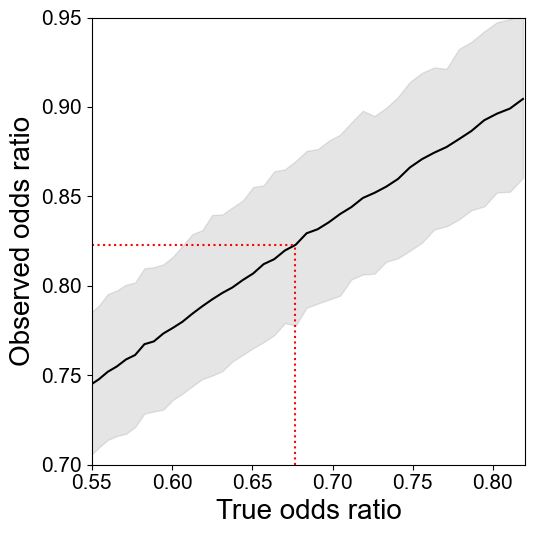

In [13]:
# Plot the results
fig,ax = plt.subplots(figsize=[5.6,5.6])
ax.plot(np.exp(beta_list), np.exp(BETA_mean_list), color='k')
ax.fill_between(np.exp(beta_list), np.exp(BETA_CI_L_list), np.exp(BETA_CI_H_list),alpha=0.2, color='gray')
ax.hlines(y=0.823, xmin=0.55, xmax=0.6765, linestyles=':', color='r')
ax.vlines(x=0.6765, ymin=0.70, ymax=0.823, linestyles=':', color='r')

ax.set_xlim(0.55, 0.82)
ax.set_ylim(0.7, 0.95)
ax.set_xlabel('True odds ratio', size=20)
ax.set_ylabel('Observed odds ratio', size=20)

plt.tight_layout()
plt.savefig('Effect_size_analysis.pdf')